# Classifier comparison
Comparison of different classifiers for given embedding

In [1]:
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties, findfont
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm.auto import tqdm

from sentence_topology.classification.analysis import analyze_classifier
from sentence_topology.utils.transform import EmbeddingsLoader
from sentence_topology.utils.io import load_corpus

In [2]:
CM = 1 / 2.54
sns.set_theme(context="paper", style="whitegrid", palette="muted")
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"

In [3]:
EMBEDDINGS = {
    "paraphrase-multilingual-MiniLM-L12-v2.tsv": "sbert",
    "Phrase_Embedding.tsv": "phrase-bert",
    "LaBSE.tsv": "labse",
    "tfidf_all.tsv": "tfidf",
    "mixup_by_seed_paraphrase-multilingual-MiniLM-L12-v2.tsv": "mixup-sbert",
}
MODEL_NAME = {
    "sbert": "SBERT",
    "phrase-bert": "Phrase BERT",
    "tfidf": "TF-IDF",
    "mixup-sbert": "mixed-up SBERT",
    "labse": "LaBSE"
}
EMBED_DIR = "../embeddings"
CONTEXT_MODE = "diff"
EQUALIZE_TRANS = True
CLASSIFIERS = {
    "sbert": {
        "RandomForest": RandomForestClassifier(
            max_depth=25,
            n_estimators=200,
            min_samples_split=20,
        ),
        "SVM": make_pipeline(
            StandardScaler(),
            SVC(gamma="auto", kernel="rbf"),
        ),
        "KNN": make_pipeline(
            StandardScaler(),
            KNeighborsClassifier(n_neighbors=3, weights="distance"),
        ),
    }
}
CLASSIFIERS['phrase-bert'] = CLASSIFIERS['sbert']
CLASSIFIERS['labse'] = CLASSIFIERS['sbert']
CLASSIFIERS['tfidf'] = CLASSIFIERS['sbert']
CLASSIFIERS['mixup-sbert'] = CLASSIFIERS['sbert']

In [9]:
embed_loader = EmbeddingsLoader(
    EMBED_DIR,
    context_mode=CONTEXT_MODE,
    equalize_trans=EQUALIZE_TRANS,
)

embeds_comparison = {}
for embed_filepath in embed_loader.list_all(tqdm_enable=True):
    if embed_filepath not in EMBEDDINGS:
        continue

    embed_name = EMBEDDINGS[embed_filepath]
    embed = embed_loader.load(embed_filepath)

    analysis_results = {}
    for cls_key, cls in CLASSIFIERS[embed_name].items():
        analysis_results[cls_key] = analyze_classifier(
            embed, cls, cross_validation=True
        )

    embeds_comparison[embed_name] = analysis_results

Processing embeddings:   0%|          | 0/37 [00:00<?, ?it/s]

/home/dburian/.local/share/python-venvs/sentence_topo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dburian/.local/share/python-venvs/sentence_topo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dburian/.local/share/python-venvs/sentence_topo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [76]:
embeds_comparison.keys()

dict_keys(['sbert', 'phrase-bert', 'labse', 'tfidf', 'mixup-sbert'])

In [54]:
SEPARABLE = [
    'ban',
    'possibility',
    'past',
    'future',
    'opposite meaning',
    'generalization',
    'formal sentence',
    'nonstandard sentence',
    'paraphrase',
]
INSEPARABLE = [
    'different meaning',  
    'minimal change',
    'simple sentence',
    'nonsense',
]
TRANS_ORDER = [
    "ban",
    "possibility",
    "future",
    "past",
    "opposite meaning",
    "generalization",
    "formal sentence",
        "minimal change",
    "nonsense",
    "different meaning", 
    "nonstandard sentence",
    "simple sentence",
    "paraphrase"
]


In [24]:
def get_comparison_data(embed_name):
    analysis_results = embeds_comparison[embed_name]

    comp = pd.DataFrame(
        {
            cls_name: analysis.report.loc["f1-score"]
            for cls_name, analysis in analysis_results.items()
        }
    )

    comp = comp.stack().reset_index()
    comp.columns = ["Transformation", "Classifier", "F1-score"]
    comp['Hypothetically separable'] = comp['Transformation'].isin(SEPARABLE)
    comp['Embedding'] = MODEL_NAME[embed_name]
    return comp

Text(0.5, 0.98, 'F1-score')

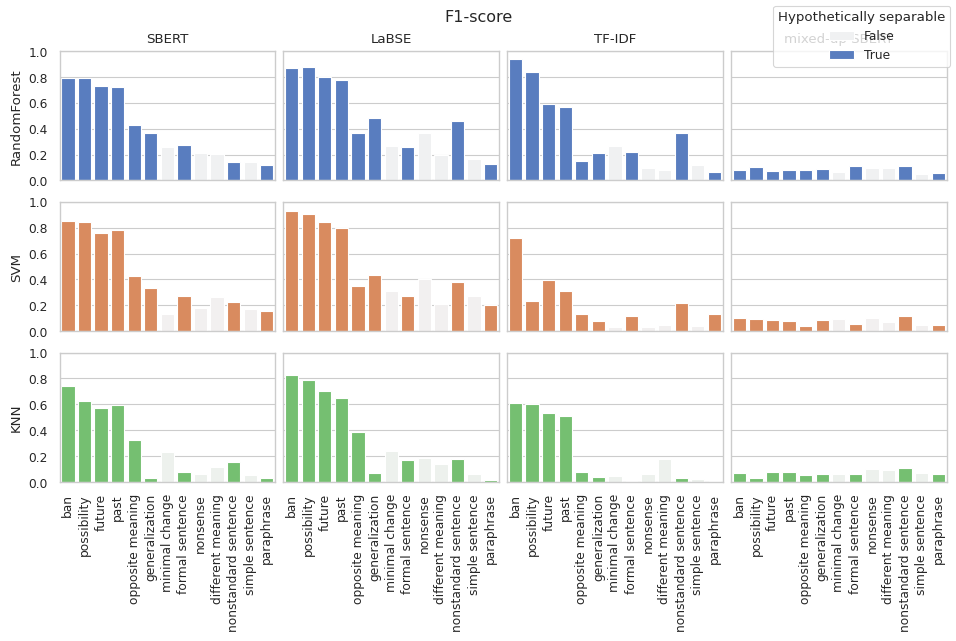

In [22]:
fig, axes = plt.subplots(3, 4, figsize=(24* CM, 16 *CM), sharey=True, sharex=True,layout='constrained')
legend = None
for cls_name, axis_row, color in zip(['RandomForest', 'SVM', 'KNN'], axes, sns.color_palette(n_colors=3)):
    for embed_name, axis in zip(['sbert', 'labse', 'tfidf', 'mixup-sbert'], axis_row):
        comp = get_comparison_data(embed_name)
        comp = comp[comp['Classifier'] == cls_name]
        sns.barplot(comp, x="Transformation", y="F1-score", hue='Semantically unique', order=TRANS_ORDER, dodge=False, ax=axis, color=color)
        axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=90)
        axis.set_ylim((0, 1))
        axis.set_xlabel("")
        legend = axis.get_legend()
        axis.legend().remove()
        if embed_name != 'sbert':
            axis.set_ylabel("")
        else:
            axis.set_ylabel(cls_name)
        if cls_name == 'RandomForest':
            axis.set_title(MODEL_NAME[embed_name])

fig.legend(*axes[0][0].get_legend_handles_labels(), title='Hypothetically separable')
fig.suptitle('F1-score')

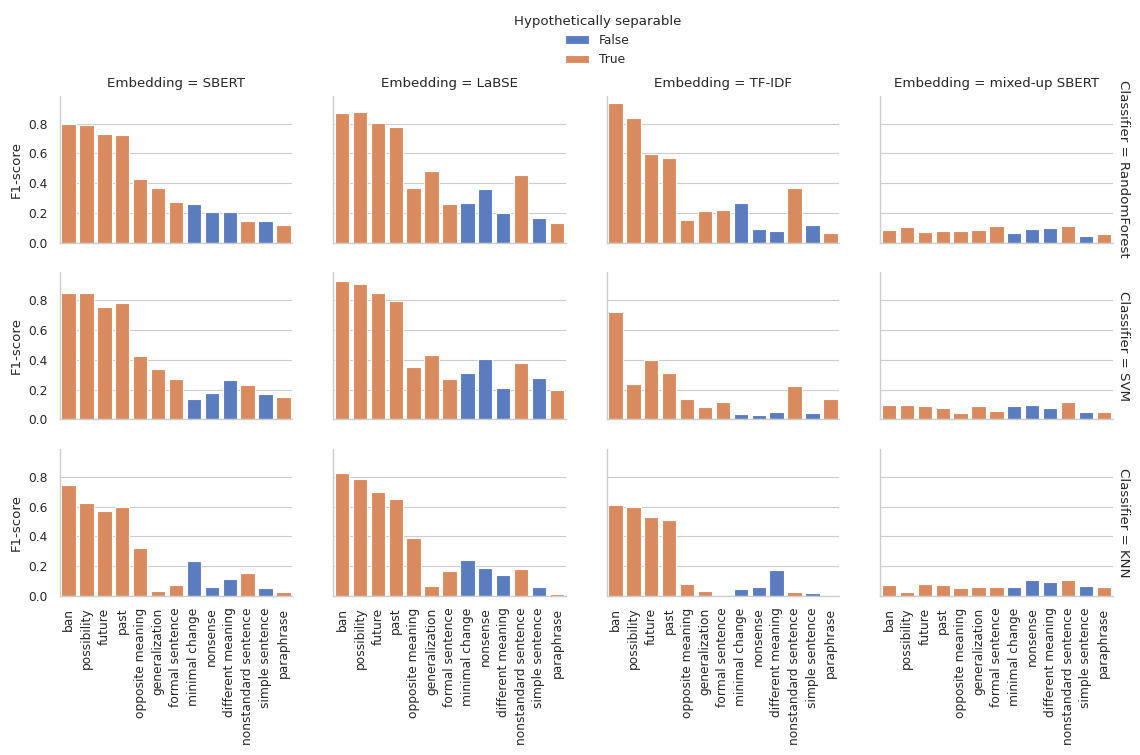

In [64]:
comp = pd.concat([get_comparison_data(embed_name) for embed_name in ['sbert', 'labse', 'tfidf', 'mixup-sbert']])
g = sns.FacetGrid(comp, col='Embedding', row='Classifier', height=5*CM, aspect=3/2, margin_titles=True)
g.map_dataframe(sns.barplot,
    x='Transformation',
    y='F1-score',
    hue='Hypothetically separable',
    order=TRANS_ORDER,
    dodge=False,
    palette=sns.color_palette(n_colors=2)
)


g.add_legend(title='Hypothetically separable', loc='upper center', bbox_to_anchor=(0.45, 1.1))
g.tick_params(axis='x', rotation=90)
g.set_xlabels('')
#g.map_dataframe(add_title)
#g.figure.tight_layout()

In [65]:
g.figure.savefig("figs/cls_new.png")

In [ ]:
word_uniqueness = {}
for embed_filepath in embed_loader.list_all(tqdm_enable=True):
    if embed_filepath not in EMBEDDINGS:
        continue

    embed_name = EMBEDDINGS[embed_filepath]
    embed = embed_loader.load(embed_filepath)

    

In [4]:
costra = pd.DataFrame(load_corpus('../data/COSTRA1.1.tsv'))
costra

,id,seed_id,trans,text,more_trans,less_trans,similar,dissimilar
0,0,1,ban,V bulváru je zakázáno psát dobrý příběhy a dos...,[],[],[],[]
1,1,1,ban,V bulváru nesmí psát dobrý a dost podrobný pří...,[],[],[],[]
2,2,1,ban,V bulváru se nesmí psát dobré příběhy ani dost...,[],[],[],[]
3,3,1,different meaning,Do bulváru se píšou příběhy dobře i dost podro...,[],[],[],[]
4,4,1,different meaning,"Podrobnosti tvoří základ dobrého příběhu, bez ...",[],[],[],[]
...,...,...,...,...,...,...,...,...
6963,6963,99,paraphrase,Přes sociální nástroje chtěli na tyto případy ...,[],[],[],[]
6964,6964,99,paraphrase,Také díky médiím na rovině virtuální chtěli na...,[],[],[],[]
6965,6965,99,possibility,Za pomoci sociálních médií mohli chtít k těmto...,[],[],[],[]
6966,6966,99,seed,Za pomoci sociálních médií chtěli k těmto příp...,"[6960, 6961]","[6946, 6947, 6949, 6950, 6952, 6953, 6956, 6959]",[],[]


In [5]:
for idx, row in tqdm(costra.iterrows()):
    other_sentences = costra[(costra['seed_id'] == row.seed_id) & (costra['trans'] != row.trans)]
    other_words = set((other_sentences['text'] + " ").sum().split())
    sent_words = set(row.text.split())

    costra.loc[idx, 'words_unique'] = len(sent_words - other_words)/len(sent_words)
        

0it [00:00, ?it/s]

/tmp/ipykernel_327965/1345999651.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(costra, x='words_unique', hue='trans')


<Axes: xlabel='words_unique', ylabel='Density'>

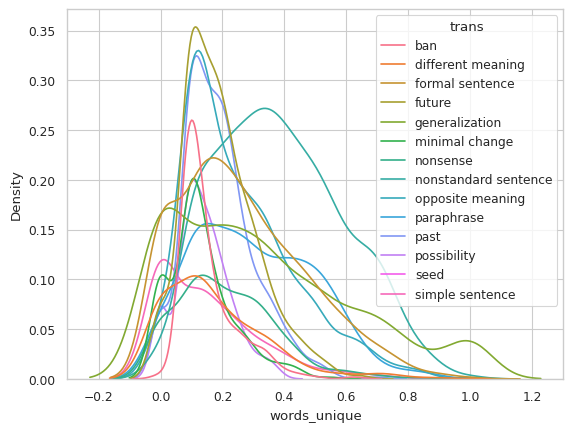

In [51]:
sns.kdeplot(costra, x='words_unique', hue='trans')

Text(0.5, 0, 'Fraction of unique words')

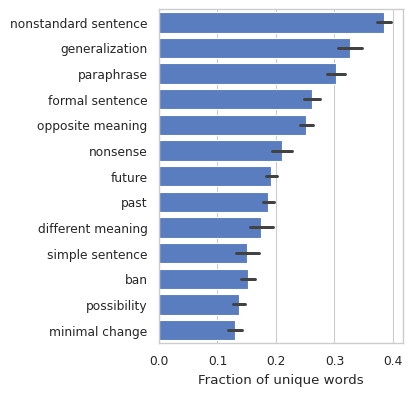

In [6]:
fig, axis = plt.subplots(1, 1, figsize=(8*CM, 11*CM))
order = ["nonstandard sentence", "generalization", "paraphrase", "formal sentence", "opposite meaning", "nonsense", "future", "past", "different meaning", "simple sentence", "ban", "possibility", "minimal change"]
color = sns.color_palette(n_colors=1)[0]
sns.barplot(costra, y='trans', x='words_unique', order=order, color=color, ax=axis, orient='h')
#axis.set_ylabel("Transformation")
axis.set_ylabel("")
axis.set_xlabel("Fraction of unique words")
#ticks = [0, 0.125, 0.25, 0.375, 0.5]
#axis.set_xticks(ticks, [str(t) for t in ticks]) 


In [7]:
costra.groupby('trans').agg({'words_unique': 'mean'})

,words_unique
trans,
ban,0.152106
different meaning,0.174403
formal sentence,0.261263
future,0.191957
generalization,0.326990
minimal change,0.129646
nonsense,0.210030
nonstandard sentence,0.385235
opposite meaning,0.252087


In [76]:
fig.savefig('figs/trans_word_uniqueness.png')